# Crosscheck the BDT with cross-validation on Run 1 data
- Author: Vincenzo Battista (vibattis)
- Start Date: 2018-01-09
- End Date: 2018-01-10
    
# Goals
- tune hyperparameters for Run 1 OSElectron tagger (with newly optimized cuts) on Run 1 data

# Conclusion
- the default choice of ntrees=300 and max depth=3 is good enough

In [1]:
# https://ipython.org/ipython-doc/dev/config/extensions/autoreload.html
%reload_ext autoreload
%autoreload 1

# https://github.com/jrjohansson/version_information
%reload_ext version_information
%version_information numpy, scipy, matplotlib, pandas, root_pandas, root_numpy

import matplotlib
matplotlib.rc_file('../../lhcb-matplotlibrc/matplotlibrc')
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)
%config InlineBackend.figure_format = 'retina'

In [2]:
#"Standard" libraries import
import pandas as pd
import math
from root_pandas import read_root
import numpy as np
#import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xgboost
from xgboost import XGBClassifier
from xgboost.core import Booster
from xgboost.sklearn import XGBModel
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import column_or_1d
from sklearn.metrics import roc_curve
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from uncertainties import ufloat
from scipy.stats import ks_2samp
from IPython.display import Image, display
import json
import os, sys

#"Local" library import
sys.path.append("../../python/")
import calib_models, calib_utils, data_utils, plot_utils, tagging_utils, mva_utils, stat_utils

#Set up logging
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

/afs/cern.ch/work/v/vibattis/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
#Set LHCb style for plots
#import matplotlib
#matplotlib.rc_file('../../lhcb-matplotlibrc/matplotlibrc')
#matplotlib.use('TkAgg')

In [4]:
# Customizations
#%matplotlib inline
#plt.rcParams['figure.figsize'] = (12, 12)
#%config InlineBackend.figure_format = 'retina'

In [5]:
# notebook name
notebook_name = '2018-01-09-vibattis-OSElectron-bdt-crossvalidation-sWeights_Run1'
# Find the notebook the saved figures came from
fig_prefix = '../figures/'+notebook_name+'/'
# Directory to store weights
weights_prefix = '../weights/'+notebook_name+'/'

In [6]:
# input file and tree names
file_in_run1_train = '/afs/cern.ch/work/v/vibattis/public/OSElectronOpt2017/OptCutsNominalRun1/Selected_Bu2JpsiK_OSe_bdt.root'
file_in_run1_eval1 = '/afs/cern.ch/work/v/vibattis/public/OSElectronOpt2017/OptCutsNominalRun1/Selected_Bu2JpsiK_OSe_eval1.root'
file_in_run1_eval2 = '/afs/cern.ch/work/v/vibattis/public/OSElectronOpt2017/OptCutsNominalRun1/Selected_Bu2JpsiK_OSe_eval2.root'
base_file = ['/eos/lhcb/wg/FlavourTagging/tuples/development/data/B2CC/20171122_vmueller/DTT_2011_Reco14Strip21r1_DIMUON_Bu2JpsiK_sW.root',
            '/eos/lhcb/wg/FlavourTagging/tuples/development/data/B2CC/20171122_vmueller/DTT_2012_Reco14Strip21_DIMUON_Bu2JpsiK_sW.root']
base_tree = 'DecayTree'

In [7]:
pfx="B_OSMuonDev_TagPartsFeature_"
mva_dictionary = {
    "Features": {
       #pfx+"P"                     : {"bins": 80, "log": True, "label": "$P$ [MeV/c]"},# "max":50000},
       pfx+"PT"                    : {"bins": 80, "log": True, "label": "$P_T$ [MeV/c]"},# "max":4000},
       pfx+"IPPUSig"               : {"bins": 80, "log": True, "label": "$\sigma_{IPPU}/IPPU$"},
       pfx+"TRGHP"                 : {"bins": 80, "log": True, "label": "Ghost probability"},
       #pfx+"TRCHI2DOF"             : {"bins": 80, "log": True, "label": "Track $\chi^2/ndof$"},
       pfx+"countTracks"           : {"bins": 60, "log": True, "label": "Number of tracks"},
       pfx+"Signal_PT"             : {"bins": 80, "log": True, "label": "Signal $P_{T}$ [Mev/c]"},# "max":40000},
       pfx+"eOverP"                : {"bins": 80, "log": True, "label": "e/P"},
       pfx+"AbsIP"                 : {"bins": 80, "log": True, "label": "|IP| [mm]"},# "max":40},
       pfx+"IPErr"                 : {"bins": 80, "log": True, "label": "$\sigma_{IP}$ [mm]"},# "max":0.4},
       pfx+"BPVIPCHI2"             : {"bins": 80, "log": True, "label": "BPV IP $\chi^2$"},# "max":50000},
       #pfx+"DeltaQ"                : {"bins": 80, "log": True, "label": "$\Delta Q$ [MeV/c]"},# "max":5000},
       #pfx+"etaDistance"           : {"bins": 80, "log": True, "label": "$\Delta\eta$"},# "max":5}
       pfx+"DeltaR"                : {"bins": 80, "log": True, "label": "$\Delta R$ [mm]"},
        },
    "Target": {
        'target==0' : 'Wrong Tag',                                                                                                                                                                          
        'target==1' : 'Right Tag' } 
    }

In [8]:
# create train and test/calib sample
from data_utils import load_data_fast, sel_efficiency, tot_event_number

train_query = 'eventNumber % 8 >= 2 & eventNumber % 8 <= 5'
eval1_query = 'eventNumber % 8 == 6'
eval2_query = 'eventNumber % 8 == 7'

df_train_run1 = load_data_fast(file_in_run1_train)
df_eval1_run1 = load_data_fast(file_in_run1_eval1)
df_eval2_run1 = load_data_fast(file_in_run1_eval2)

target = '(abs(B_ID) / B_ID) == -B_OSMuonDev_TagPartsFeature_Q'
df_train_run1['target'] = df_train_run1.eval(target)
df_eval1_run1['target'] = df_eval1_run1.eval(target)
df_eval2_run1['target'] = df_eval2_run1.eval(target)

train_event_number_run1 = 0.0
eval1_event_number_run1 = 0.0
eval2_event_number_run1 = 0.0
for file in base_file:
    train_event_number_run1 += tot_event_number(file, 
                                    base_tree,
                                    preselection = 'B_LOKI_MASS_JpsiConstr_NoPVConstr>0 & '+train_query,
                                    presel_column = ['B_LOKI_MASS_JpsiConstr_NoPVConstr', 'eventNumber'])

    eval1_event_number_run1 += tot_event_number(file, 
                                    base_tree,
                                    preselection = 'B_LOKI_MASS_JpsiConstr_NoPVConstr>0 & '+eval1_query,
                                    presel_column = ['B_LOKI_MASS_JpsiConstr_NoPVConstr', 'eventNumber'])

    eval2_event_number_run1 += tot_event_number(file, 
                                    base_tree,
                                    preselection = 'B_LOKI_MASS_JpsiConstr_NoPVConstr>0 & '+eval2_query,
                                    presel_column = ['B_LOKI_MASS_JpsiConstr_NoPVConstr', 'eventNumber'])

print(f'Total number of event before selection in the train sample: {train_event_number_run1}')
print(f'Total number of event before selection in the test sample: {eval1_event_number_run1}')
print(f'Total number of event before selection in the calib sample: {eval2_event_number_run1}')
print(f'...sum = {train_event_number_run1+eval1_event_number_run1+eval2_event_number_run1}')

print('Selection efficiency on train sample:')
train_selection_efficiency_run1 = sel_efficiency(df_train_run1, 
                                                 train_event_number_run1)
print('Selection efficiency on test sample:')
eval1_selection_efficiency_run1 = sel_efficiency(df_eval1_run1, 
                                                eval1_event_number_run1)
print('Selection efficiency on calib sample:')
eval2_selection_efficiency_run1 = sel_efficiency(df_eval2_run1, 
                                                 eval2_event_number_run1)

merged_event_number_run1 = eval1_event_number_run1+eval2_event_number_run1
df_merged_run1 = pd.concat([df_eval1_run1,df_eval2_run1])
print('Selection efficiency on the "non-training" sample:')
merged_selection_efficiency_run1 = sel_efficiency(df_merged_run1, 
                                                merged_event_number_run1)

Total number of event before selection in the train sample: 587680.1169256214
Total number of event before selection in the test sample: 147048.3795529086
Total number of event before selection in the calib sample: 147149.87218918136
...sum = 881878.3686677114
Selection efficiency on train sample:
INFO:data_utils:ε = 3.4326+/-0.0237%
Selection efficiency on test sample:
INFO:data_utils:ε = 3.4808+/-0.0478%
Selection efficiency on calib sample:
INFO:data_utils:ε = 3.4315+/-0.0475%
Selection efficiency on the "non-training" sample:
INFO:data_utils:ε = 3.4561+/-0.0337%


INFO:mva_utils:train BDT over the following features:
['B_OSMuonDev_TagPartsFeature_PT', 'B_OSMuonDev_TagPartsFeature_IPPUSig', 'B_OSMuonDev_TagPartsFeature_TRGHP', 'B_OSMuonDev_TagPartsFeature_countTracks', 'B_OSMuonDev_TagPartsFeature_Signal_PT', 'B_OSMuonDev_TagPartsFeature_eOverP', 'B_OSMuonDev_TagPartsFeature_AbsIP', 'B_OSMuonDev_TagPartsFeature_IPErr', 'B_OSMuonDev_TagPartsFeature_BPVIPCHI2', 'B_OSMuonDev_TagPartsFeature_DeltaR']
INFO:mva_utils:average performance for maximum_depth=2 and n_estimators=100:
            tagging power = 0.43837883061948635 +/- 0.006316333518379644 %
            roc auc = 57.132639416430166 +/- 0.5207295612254366 %
            
INFO:mva_utils:average performance for maximum_depth=2 and n_estimators=300:
            tagging power = 0.46156671130809 +/- 0.018420668815133823 %
            roc auc = 57.730107262684115 +/- 0.43343953655863404 %
            
INFO:mva_utils:average performance for maximum_depth=2 and n_estimators=600:
            tagging pow

/afs/cern.ch/work/v/vibattis/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(2, 1000, 3, 300)

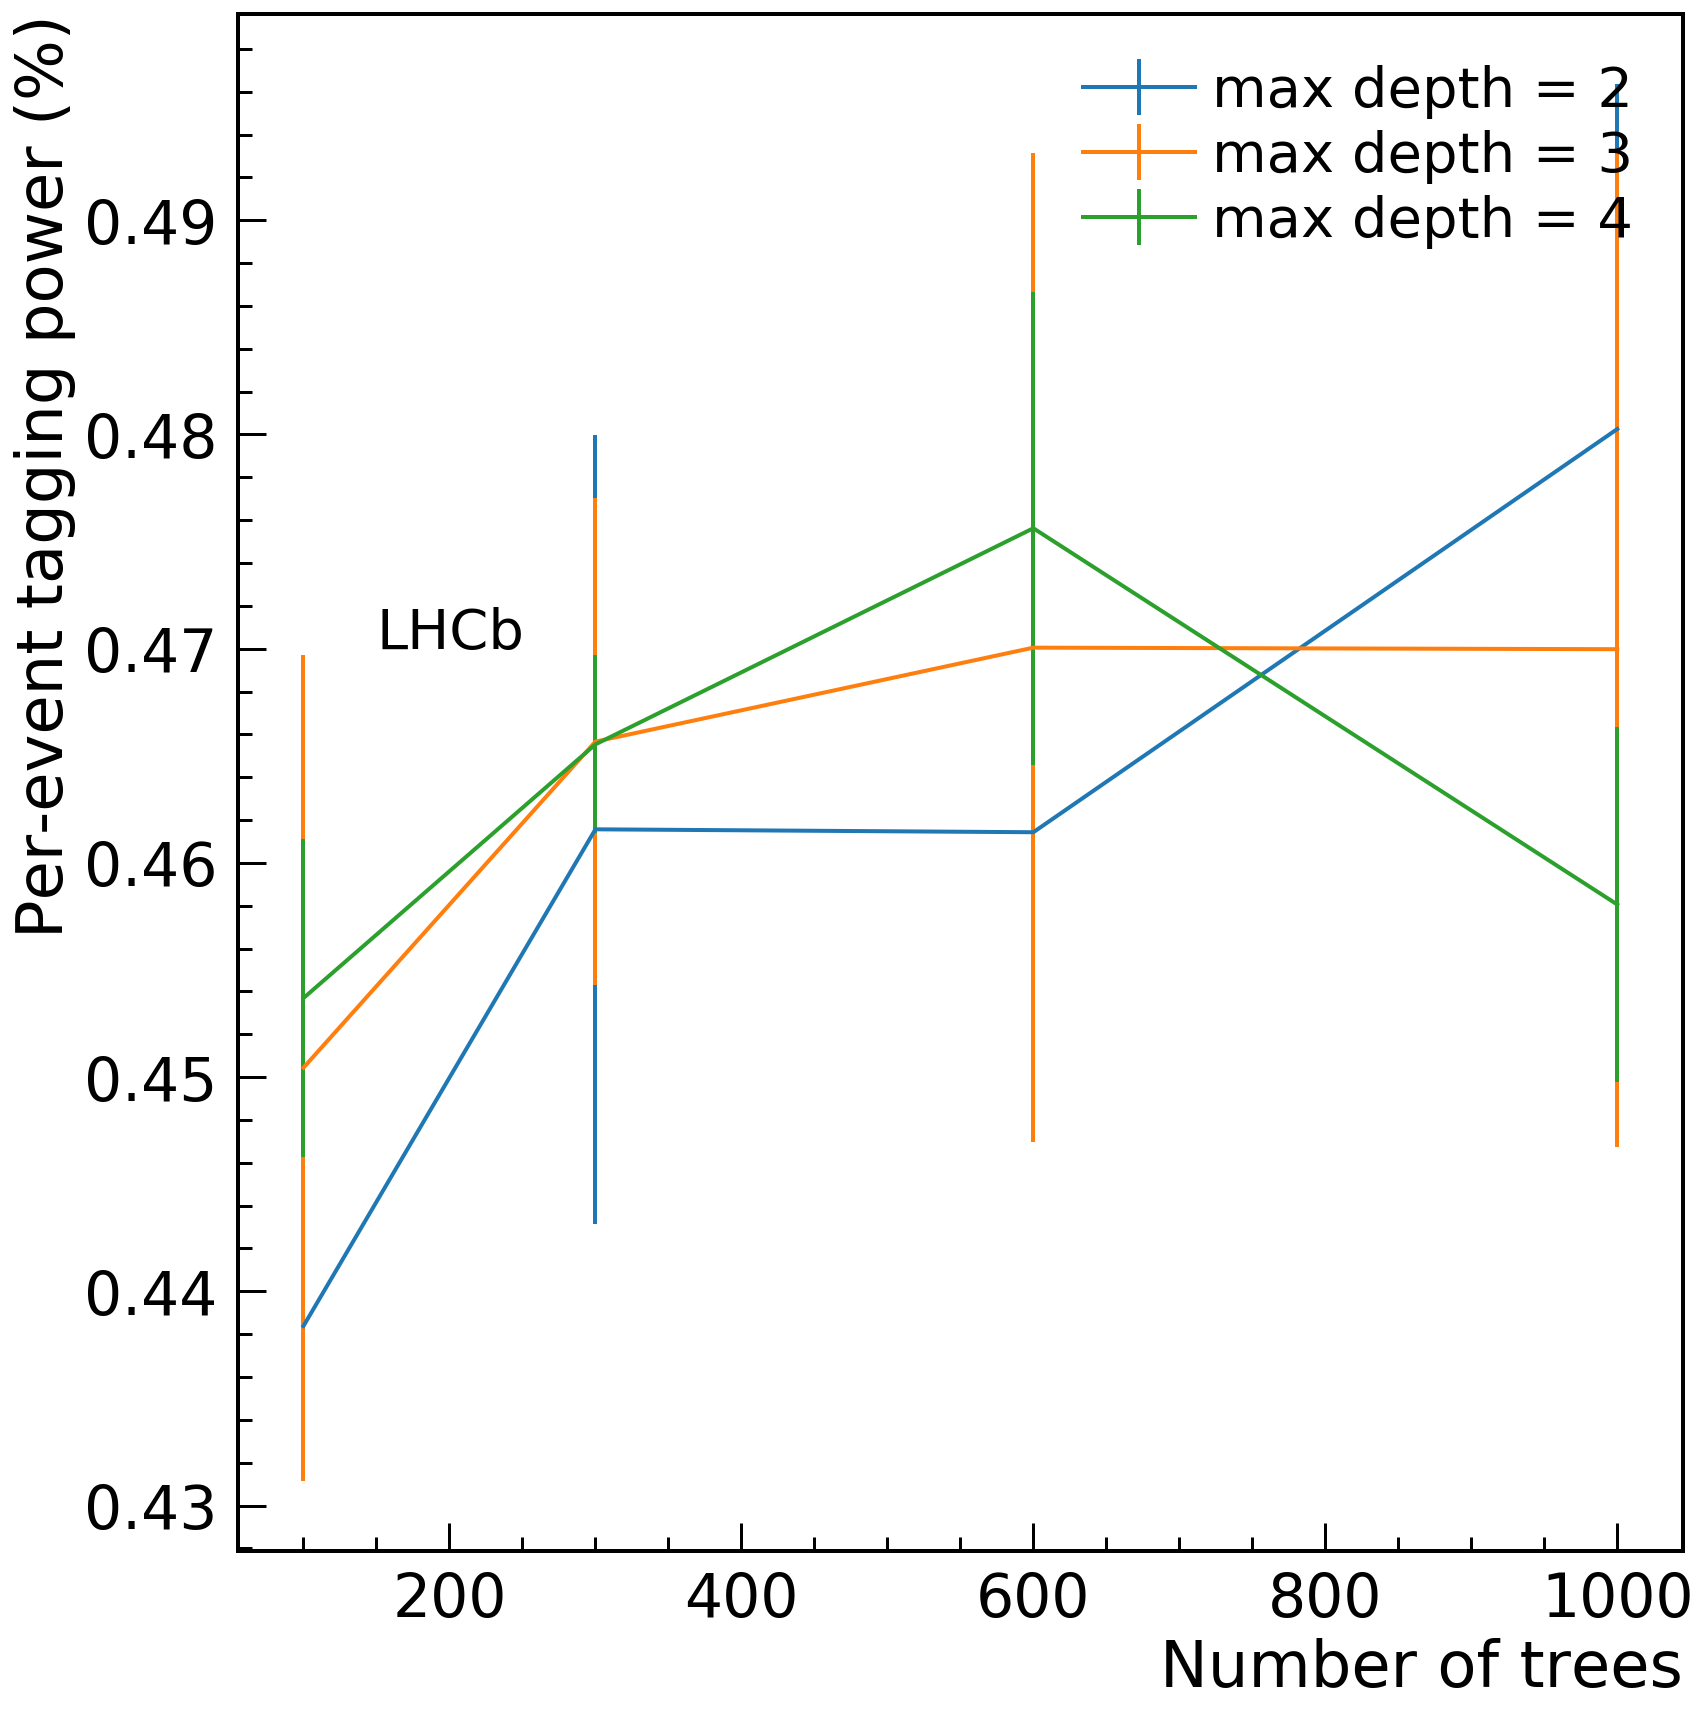

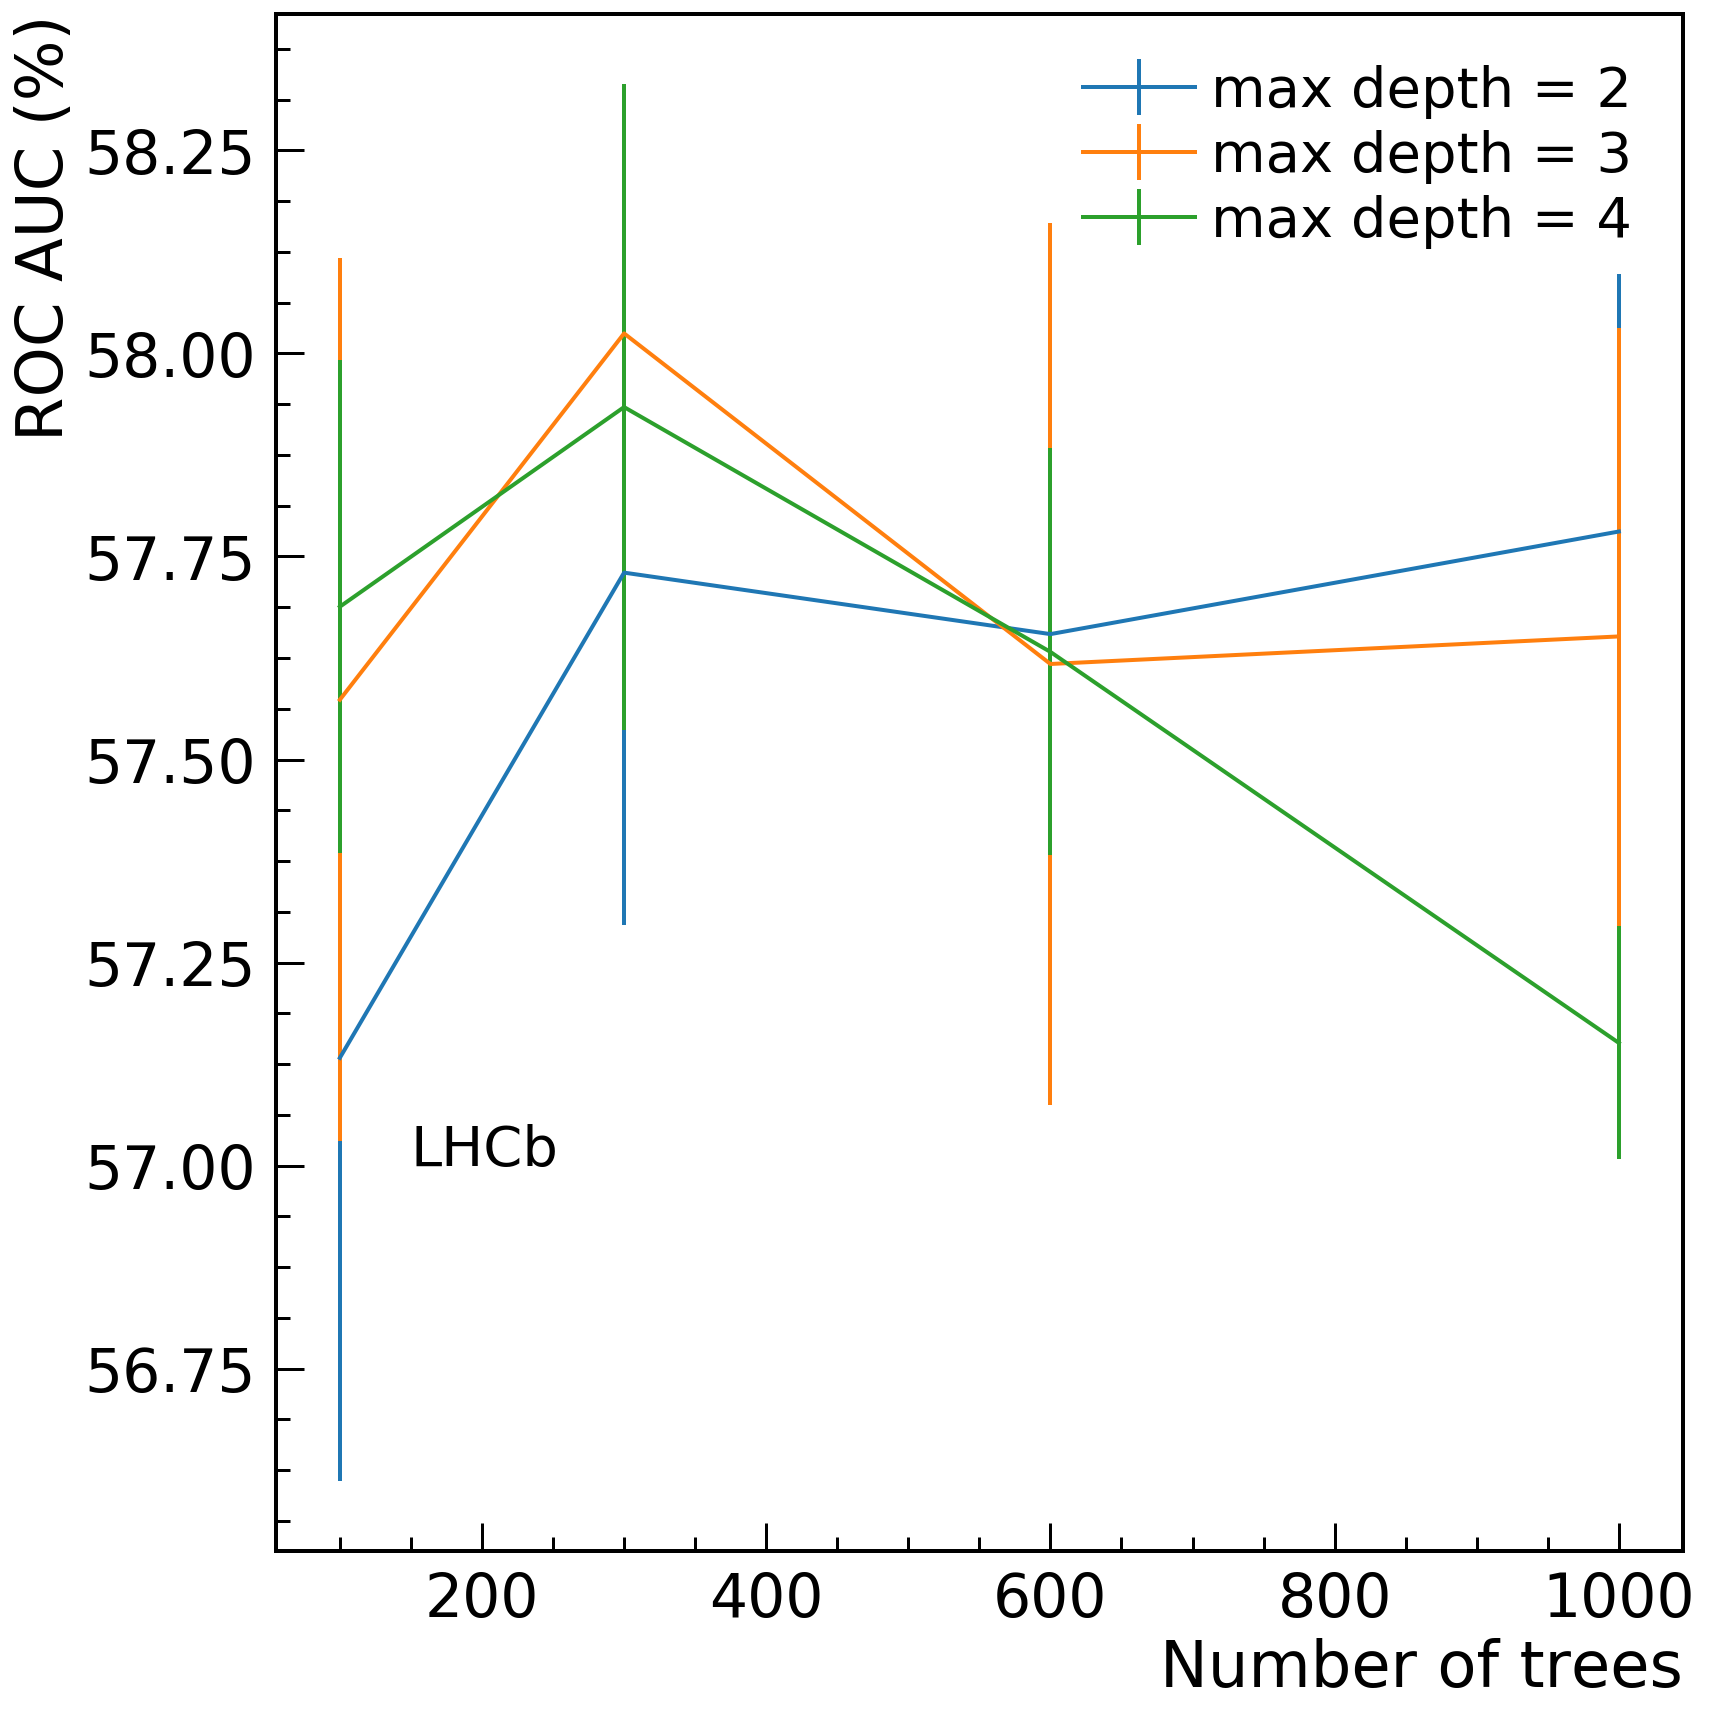

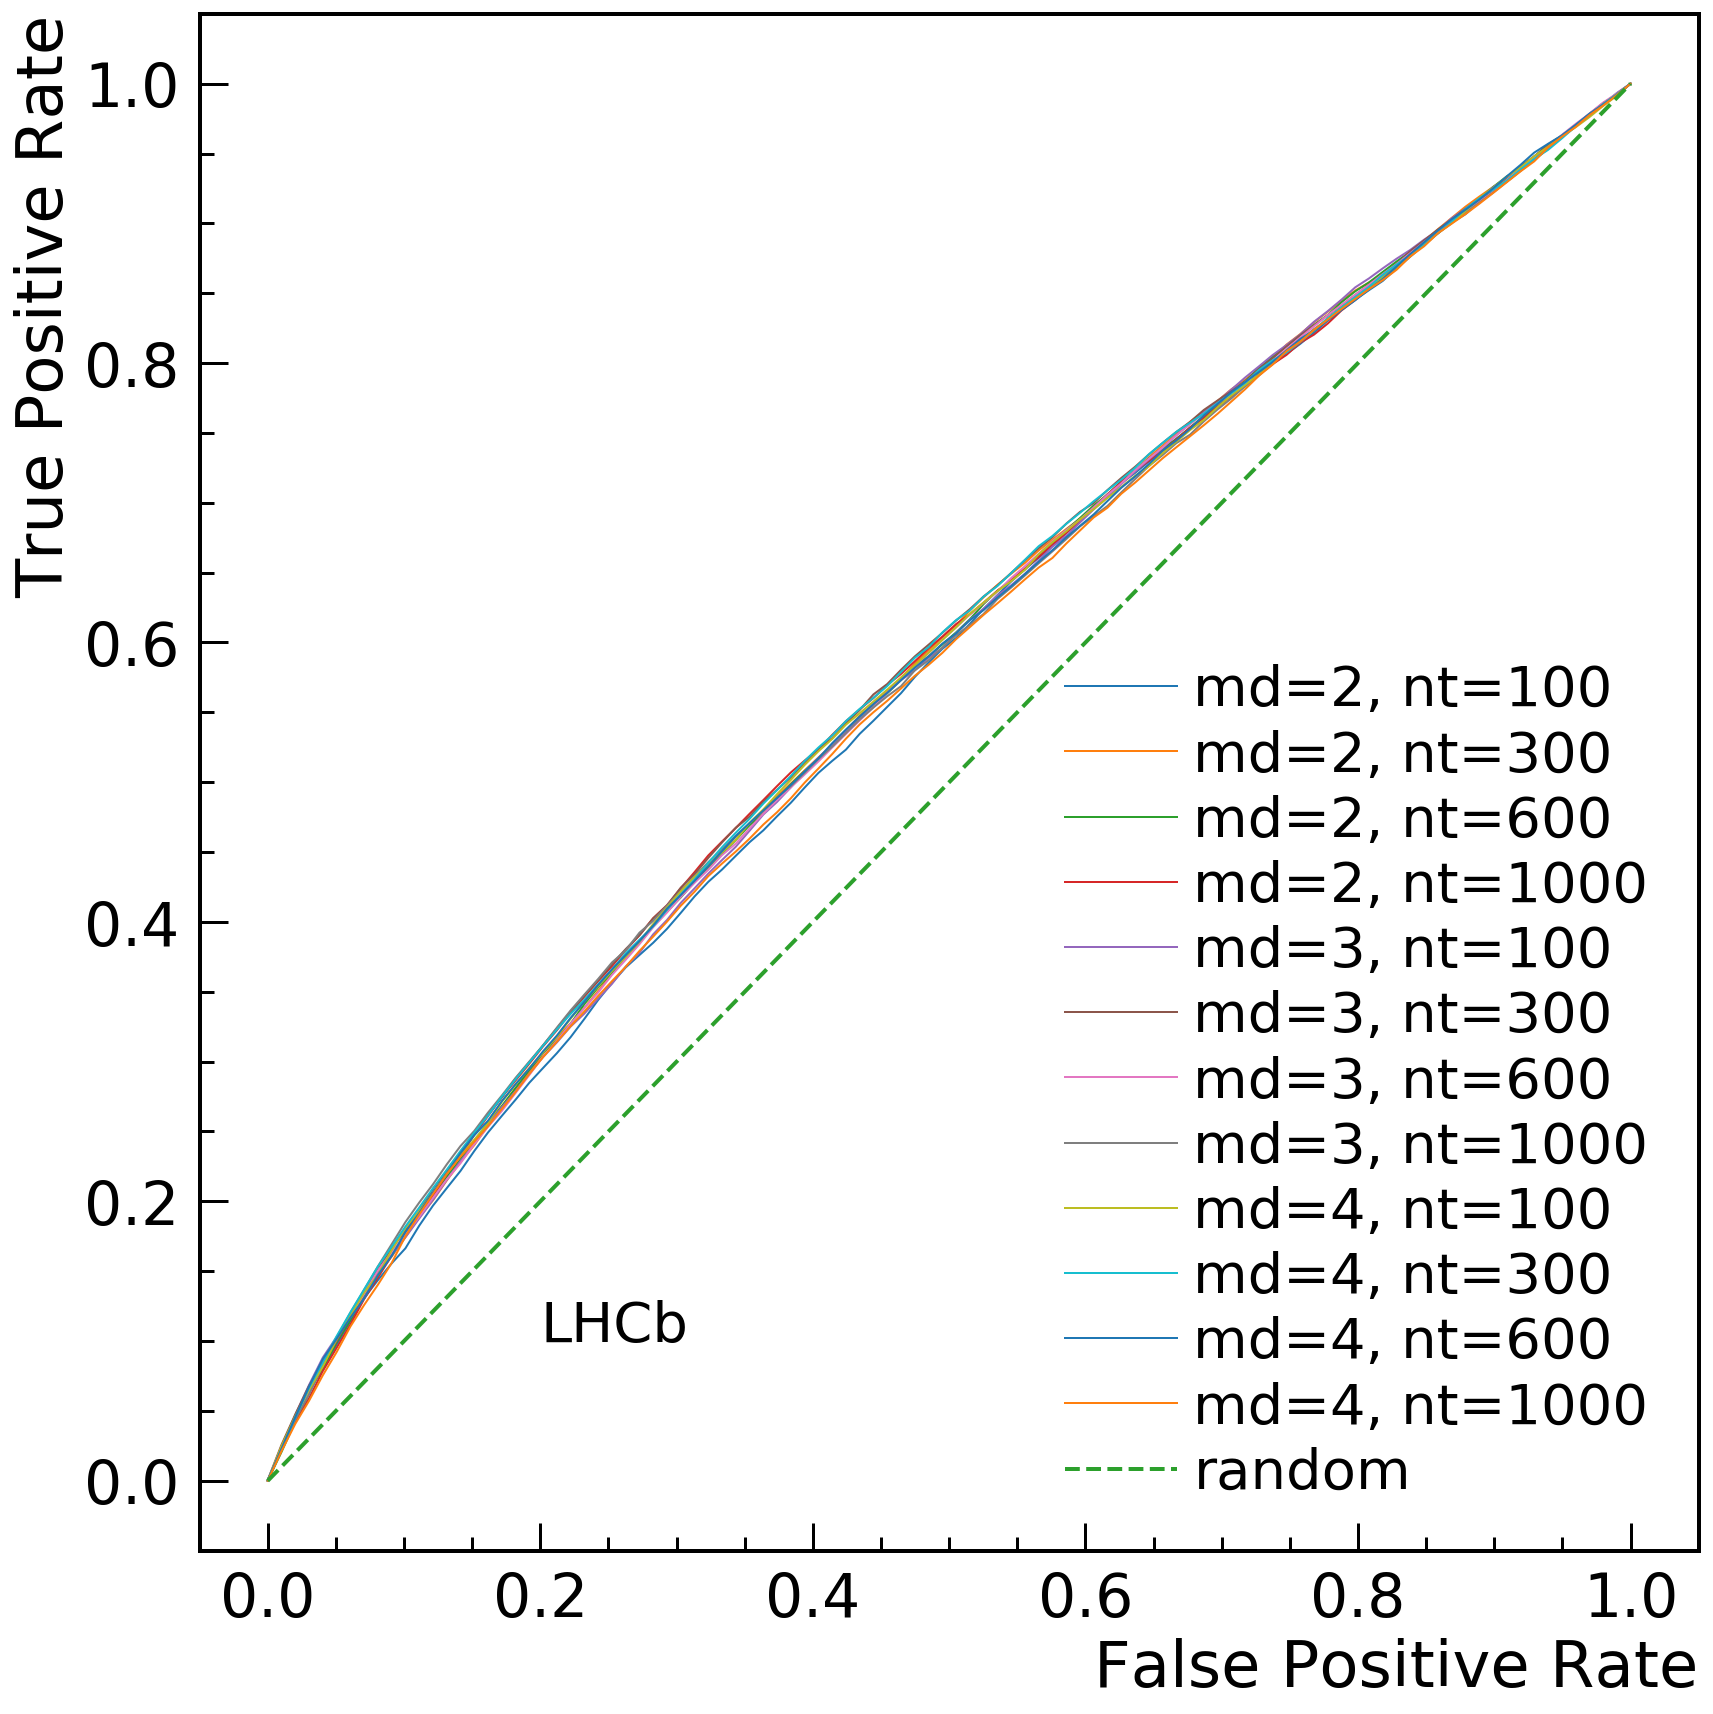

In [9]:
#Determine max depth and number of tree which yield best tagging power over cross-validation
#do this test only on data with optimised cuts
from mva_utils import xgb_cv_tuning

xgb_cv_tuning(df_train_run1,
              [100,300,600,1000], #n_estimators
              [2,3,4],  #max_depth
              train_event_number_run1,
              'B_OSMuonDev_TagPartsFeature_PT', #max pT
              list(mva_dictionary["Features"].keys()),
              fig_prefix,
              sample_weight = 'SigYield_sw',
              nBootstrap=1,
              lhcb_label = {                                                                                                                                                         
                           'x'     : {'tp': 150, 'roc_auc': 150},                                                                                                                                                        
                           'y'     : {'tp': 0.47, 'roc_auc' : 57},                                                                                                                                                        
                           'label' : 'LHCb',                                                                                                                                                   
                           'size'  : 28})